# 基本信息
1. 实验名称：卷积神经网络实验
2. 姓名：唐林
3. 学号：20281087
4. 日期：2022.12.12

In [ ]:
# 一、任务1

## 1.1 任务内容

1. 手写二维卷积的实现，并从至少一个数据集上进行实验，这里我选取了车辆分类数据集（后面的实验都是用的车辆分类数据集），主要根据数据集的大小，手动定义二维卷积操作，如：自定义单通道卷积、自定义多通道卷积、自定义卷积层等。
2. 任务目的：手写二维卷积的实现，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）（只用循环几轮即可）
3.使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）不同超参数的对比分析（包括卷积层数、卷积核大小、batchsize、lr等）选其中至少1-2个进行分析
4. 任务算法或原理介绍：在实验代码中有部分介绍，课件里面也有，这里不做过多的解释
5. 任务所用数据集（若此前已介绍过则可略）

## 1.2 任务思路及代码

> 以文本步骤的形式简要介绍代码思路
1. 步骤1：基本思路就是按照课件里面的步骤。先做好准备工作：读取数据集,定义卷积运算，定义填充和步幅，实现多通道输入和输出，自定义池化，封装卷积层，搭建神经网络
2. 步骤2：针对不同的要求，定义相应的要求，定义训练和测试函数，并进行训练和测试。
3. ……

## 卷积神经网络实现车辆分类

### 预处理

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

#### 读取数据集

In [2]:
def read_data(path):
	file_name = os.listdir(path)
	print(file_name)
	nums = []
	for i in range(len(file_name)):
		dir = path + '//' + file_name[i]
		dcon = os.listdir(dir)
		nums.append(len(dcon))
	train_data = []
	train_labels = []
	test_data = []
	test_labels = []

	train_num = [int(num * 4 / 5) for num in nums]
	test_num = [nums[i] - train_num[i] for i in range(len(nums))]
	print(train_num, test_num)
	for idx, name in enumerate(file_name):
		im_dirs = path + '/' + name
		im_path = os.listdir(im_dirs)

		index = list(range(len(im_path)))
		random.shuffle(index)
		im_path_ = list(np.array(im_path)[index])
		test_path = im_path_[:test_num[idx]]
		train_path = im_path_[test_num[idx]:]
		for img_name in train_path:
			if img_name == 'desktop.ini':
				continue
			img = Image.open(im_dirs + '/' + img_name)
			train_data.append(img)
			train_labels.append(idx)
		for img_name in test_path:
			if img_name == 'desktop.ini':
				continue
			img = Image.open(im_dirs + '/' + img_name)
			test_data.append(img)
			test_labels.append(idx)
	print("训练集大小：", len(train_data), "测试集大小：", len(test_data))
	return train_data, train_labels, test_data, test_labels

In [3]:
train_data, train_labels, test_data, test_labels = read_data('./vehicles/')

['bus', 'car', 'truck']
[175, 623, 288] [44, 156, 72]
训练集大小： 1086 测试集大小： 271


#### 图像变换与生成数据集类

In [4]:
from torchvision import transforms

In [5]:
transform = transforms.Compose([
	transforms.Resize((64, 64)),
	transforms.ToTensor(),
	transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
	def __init__(self, data, label, trans):
		self.len = len(data)
		self.data = data
		self.label = label
		self.trans = trans

	def __getitem__(self, index):
		return self.trans(self.data[index]), self.label[index]
	
	def __len__(self):
		return self.len

In [7]:
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

### 手动实现卷积网络

#### 定义卷积运算

In [8]:
import torch
from torch import nn

In [9]:
def corr2d(X, K):
	batch_size, H, W = X.shape
	k_h, k_w = K.shape
	Y = torch.zeros((batch_size, H - k_h + 1, W - k_w + 1)).to(device)
	for i in range(Y.shape[1]):
		for j in range(Y.shape[2]):
			Y[:,i, j] = (X[:, i: i + k_h, j: j + k_w] * K).sum(dim=2).sum(dim=1)
	return Y

#### 定义填充和步幅

In [10]:
def comp_conv2d(conv2d, X):
	X = X.view((1, 1) + X.shape)
	Y = conv2d(X)
	return Y.view(Y.shape[2:])

#### 实现多通道输入

In [11]:
def corr2d_multi_in(X, K):
	res = corr2d(X[:,0,:,:], K[0, :, :])
	for i in range(1, X.shape[1]):
		res += corr2d(X[:,i,:,:], K[i, :, :])
	return res

#### 实现多通道输出

In [12]:
def corr2d_multi_in_out(X, K):
	return torch.stack([corr2d_multi_in(X, k) for k in K], dim=1)

#### 自定义池化

In [13]:
def pool2d(X, pool_size, mode='max'):
	X = X.float()
	p_h, p_w = pool_size
	Y = torch.zeros(X.shape[0] - p_h + 1, X.shape[1] - p_w + 1)
	for i in range(Y.shape[1]):
		if mode == 'max':
			Y[i, j] = X[i: i + p_h, j: j + p_w].max()
		elif mode == 'avg':
			Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
	return Y

#### 封装卷积层

In [14]:
class MyConv2D(nn.Module):
	def __init__(self, in_channels, out_channels, kernel_size):
		super(MyConv2D, self).__init__()
		if isinstance(kernel_size, int):
			kernel_size = (kernel_size, kernel_size)
		self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size))
		self.bias = nn.Parameter(torch.randn(out_channels, 1, 1))
	
	def forward(self, x):
		return corr2d_multi_in_out(x, self.weight) + self.bias

#### 搭建神经网络

In [15]:
import torch.nn.functional as F
class MyConvModule(nn.Module):
	def __init__(self):
		super(MyConvModule, self).__init__()
		self.conv = nn.Sequential(
			MyConv2D(in_channels=3, out_channels=32, kernel_size=3),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True)
		)
		self.fc = nn.Linear(32, num_classes)
	
	def forward(self, X):
		out = self.conv(X)
		out = F.avg_pool2d(out, 32)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out

#### 定义训练函数

In [18]:
def train_epoch(net, data_loader, device):
	net.train()
	train_batch_num = len(data_loader)
	total_loss = 0
	correct = 0
	sample_num = 0

	for batch_idx, (data, target) in enumerate(data_loader):
		data = data.to(device).float()
		target = target.to(device).long()
		optimizer.zero_grad()
		output = net(data)
		loss = criterion(output, target)
		loss.backward()
		optimizer.step()
		total_loss += loss.item()
		prediction = torch.argmax(output, 1)
		correct += (prediction == target).sum().item()
		sample_num += len(prediction)
	loss = total_loss / train_batch_num
	acc = correct / sample_num
	return loss, acc

#### 定义测试函数

In [19]:
def test_epoch(net, data_loader, device):
	net.eval()
	test_batch_num = len(data_loader)
	total_loss = 0
	correct = 0
	sample_num = 0
	with torch.no_grad():
		for batch_idx, (data, target) in enumerate(data_loader):
			data = data.to(device).float()
			target = target.to(device).long()
			output = net(data)
			loss = criterion(output, target)
			total_loss += loss.item()
			prediction = torch.argmax(output, 1)
			correct += (prediction == target).sum().item()
			sample_num += len(prediction)
	loss = total_loss / test_batch_num
	acc = correct / sample_num
	return loss, acc

#### 训练和测试

In [20]:
classes = ('bus', 'car', 'truck')
num_classes = 3
lr = 0.01
batch_size = 64
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = MyConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

17


In [21]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
epochs = 5
for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")


epoch:0	 train_loss:0.9303	train_acc:0.5626151012891344	test_loss:0.9286	 test_acc0.5793357933579336
epoch:1	 train_loss:0.8053	train_acc:0.6565377532228361	test_loss:0.8376	 test_acc0.7121771217712177
epoch:2	 train_loss:0.7189	train_acc:0.7228360957642725	test_loss:0.7230	 test_acc0.7601476014760148
epoch:3	 train_loss:0.6797	train_acc:0.7403314917127072	test_loss:0.7019	 test_acc0.7638376383763837
epoch:4	 train_loss:0.6603	train_acc:0.7587476979742173	test_loss:0.6614	 test_acc0.7675276752767528


## 1.3 实验结果分析

> 由于训练效率太低所以只跑了一轮。
> 此时$Loss_{train}=0.8959, Accuracy_{train}=0.5853, Loss_{test}=0.8165, Accuracy_{test}=0.6177.$
> 整体的准确率不高，而且训练时间很慢

## PyTorch实现卷积神经网络

#### 搭建网络模型

In [77]:
class ConvModule(nn.Module):
	def __init__(self):
		super(ConvModule, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(128),
			nn.ReLU(inplace=True)
		)
		self.fc = nn.Linear(128, num_classes)
	
	def forward(self, X):
		out = self.conv(X)
		out = F.avg_pool2d(out, 32)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out
		

#### 训练和测试

In [78]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.01
batch_size = 64
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = ConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

17


In [79]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:0.6874	train_acc:0.7345622119815668	test_loss:0.6168	 test_acc0.7683823529411765
epoch:1	 train_loss:0.5310	train_acc:0.7907834101382488	test_loss:0.5641	 test_acc0.8014705882352942
epoch:2	 train_loss:0.5082	train_acc:0.8064516129032258	test_loss:0.7070	 test_acc0.7279411764705882
epoch:3	 train_loss:0.4915	train_acc:0.8073732718894009	test_loss:0.5882	 test_acc0.7683823529411765
epoch:4	 train_loss:0.4408	train_acc:0.8175115207373271	test_loss:0.4496	 test_acc0.8198529411764706
epoch:5	 train_loss:0.4554	train_acc:0.815668202764977	test_loss:0.6174	 test_acc0.7830882352941176
epoch:6	 train_loss:0.4587	train_acc:0.8147465437788018	test_loss:0.4844	 test_acc0.7720588235294118
epoch:7	 train_loss:0.4296	train_acc:0.8230414746543778	test_loss:0.5953	 test_acc0.7867647058823529
epoch:8	 train_loss:0.3931	train_acc:0.8451612903225807	test_loss:0.3776	 test_acc0.8198529411764706
epoch:9	 train_loss:0.3765	train_acc:0.8552995391705069	test_loss:0.4208	 test_acc0.84926470

#### 绘制图表

LOSS曲线

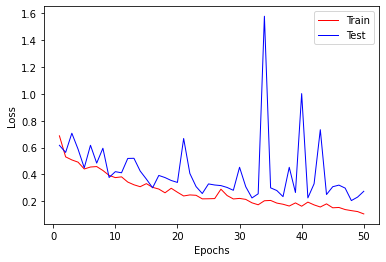

In [80]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ACCURACY曲线

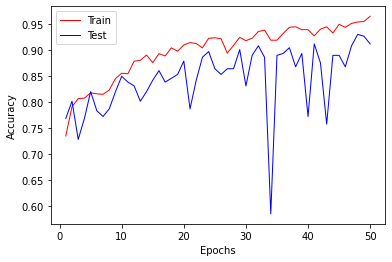

In [81]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 改变超参并对比

改变学习率为0.001

In [82]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.001
batch_size = 64
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = ConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

17


In [83]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:0.6800	train_acc:0.7400921658986175	test_loss:0.7870	 test_acc0.7058823529411765
epoch:1	 train_loss:0.5240	train_acc:0.7972350230414746	test_loss:0.5738	 test_acc0.7941176470588235
epoch:2	 train_loss:0.4651	train_acc:0.823963133640553	test_loss:0.5215	 test_acc0.7794117647058824
epoch:3	 train_loss:0.4133	train_acc:0.8488479262672811	test_loss:0.4455	 test_acc0.8639705882352942
epoch:4	 train_loss:0.3613	train_acc:0.8709677419354839	test_loss:0.3400	 test_acc0.8639705882352942
epoch:5	 train_loss:0.3407	train_acc:0.8829493087557604	test_loss:0.3279	 test_acc0.8676470588235294
epoch:6	 train_loss:0.3172	train_acc:0.8894009216589862	test_loss:0.3408	 test_acc0.8492647058823529
epoch:7	 train_loss:0.3039	train_acc:0.9032258064516129	test_loss:0.3014	 test_acc0.8676470588235294
epoch:8	 train_loss:0.2924	train_acc:0.9023041474654377	test_loss:0.4809	 test_acc0.8014705882352942
epoch:9	 train_loss:0.3104	train_acc:0.8921658986175115	test_loss:0.3132	 test_acc0.85661764

#### 绘制曲线

LOSS曲线

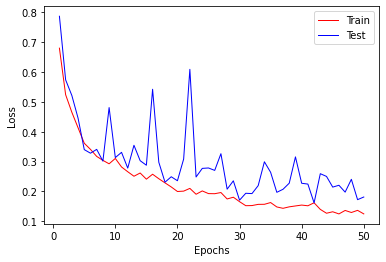

In [84]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ACCURACY曲线

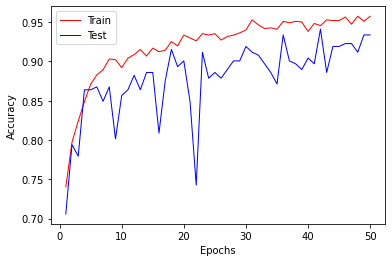

In [85]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 结果分析-调整学习率
> 将学习率调整为0.001后，LOSS下降以及ACC上升的更加缓慢，原因应该是在梯度下降中一次参数更新的值较小，所以这些值变化的相比LR=0.01要慢。

#### 改变卷积层参数

In [86]:
class ConvModule(nn.Module):
	def __init__(self):
		super(ConvModule, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(128),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(256),
			nn.ReLU(inplace=True)
		)
		self.fc = nn.Linear(256, num_classes)
	
	def forward(self, X):
		out = self.conv(X)
		out = F.avg_pool2d(out, 32)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out

In [87]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.01
batch_size = 64
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = ConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

17


In [88]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:0.8318	train_acc:0.6433179723502304	test_loss:0.7356	 test_acc0.7536764705882353
epoch:1	 train_loss:0.6119	train_acc:0.7741935483870968	test_loss:0.5261	 test_acc0.7830882352941176
epoch:2	 train_loss:0.5325	train_acc:0.8119815668202764	test_loss:0.8404	 test_acc0.7058823529411765
epoch:3	 train_loss:0.5020	train_acc:0.7907834101382488	test_loss:0.5859	 test_acc0.7720588235294118
epoch:4	 train_loss:0.4471	train_acc:0.8294930875576036	test_loss:0.4643	 test_acc0.8014705882352942
epoch:5	 train_loss:0.4266	train_acc:0.8341013824884793	test_loss:0.5486	 test_acc0.7794117647058824
epoch:6	 train_loss:0.3956	train_acc:0.8460829493087557	test_loss:0.3643	 test_acc0.8455882352941176
epoch:7	 train_loss:0.3952	train_acc:0.8516129032258064	test_loss:0.4465	 test_acc0.8235294117647058
epoch:8	 train_loss:0.3620	train_acc:0.8746543778801843	test_loss:0.4036	 test_acc0.8419117647058824
epoch:9	 train_loss:0.3536	train_acc:0.8599078341013825	test_loss:0.5935	 test_acc0.75
epoc

#### 绘制曲线

LOSS曲线

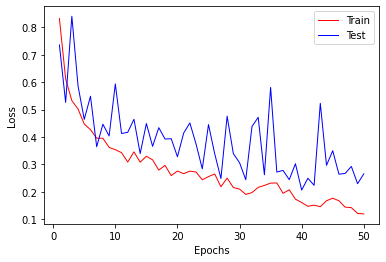

In [89]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ACCURACY曲线

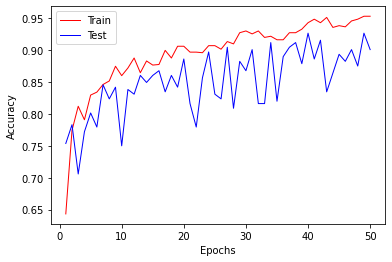

In [90]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 结果分析-改变神经元个数
> 将网络中每一个卷积层的神经元个数翻倍后，网络的性能和训练速度有所下降，可能是网络参数过多导致过拟合以及计算量增大。

In [ ]:
# 二、任务2

## 2.1 任务内容

1. 任务具体要求 从至少一个数据集上进行实验，同理，这里我选取了车辆分类数据集（后面的实验都是用的车辆分类数据集），主要在之前利用torch.nn实现二维卷积的基础上，
    为解决感受野比较的问题，将普通的卷积修改为空洞卷积，并且卷几率符合HDC条件（这里我选取了1,2,5），并且堆叠了2层HDC，即一共六层卷积层。
2. 任务要求：将空洞卷积模型的实验结果与卷积模型的结果进行分析比对，训练时间、预测精度、Loss变化等角度分析，
    不同超参数的对比分析（包括卷积层数、卷积核大小、不同dilation的选择，batchsize、lr等）选其中至少1-2个进行分析（选做）
3. 任务算法或原理介绍：步骤和二维卷积的实现差不多，这里不做过多阐述
4. 任务所用数据集（若此前已介绍过则可略）

## 2.2 任务思路及代码

> 以文本步骤的形式简要介绍代码思路
1. 步骤1：基本步骤同二维卷积实验
2. 步骤2：……
3. ……

#### 搭建空洞网络

In [107]:
class DilatedConvModule(nn.Module):
	def __init__(self):
		super(DilatedConvModule, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=2),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=5),
			nn.BatchNorm2d(128),
			nn.ReLU(inplace=True)
		)
		self.fc = nn.Linear(128, num_classes)
	
	def forward(self, X):
		out = self.conv(X)
		out = F.avg_pool2d(out, 16)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out

#### 训练和测试

In [120]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.001
batch_size = 512
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

3


In [121]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:1.0642	train_acc:0.4055299539170507	test_loss:1.0479	 test_acc0.5735294117647058
epoch:1	 train_loss:0.8589	train_acc:0.6672811059907834	test_loss:1.0130	 test_acc0.5735294117647058
epoch:2	 train_loss:0.7672	train_acc:0.6995391705069124	test_loss:0.9708	 test_acc0.6838235294117647
epoch:3	 train_loss:0.7191	train_acc:0.7400921658986175	test_loss:0.9244	 test_acc0.7426470588235294
epoch:4	 train_loss:0.6526	train_acc:0.7769585253456222	test_loss:0.8731	 test_acc0.7720588235294118
epoch:5	 train_loss:0.6212	train_acc:0.7824884792626728	test_loss:0.8207	 test_acc0.7352941176470589
epoch:6	 train_loss:0.5988	train_acc:0.7861751152073733	test_loss:0.7732	 test_acc0.7242647058823529
epoch:7	 train_loss:0.5969	train_acc:0.7963133640552995	test_loss:0.7274	 test_acc0.7573529411764706
epoch:8	 train_loss:0.5556	train_acc:0.8064516129032258	test_loss:0.6908	 test_acc0.7720588235294118
epoch:9	 train_loss:0.5606	train_acc:0.8046082949308756	test_loss:0.6617	 test_acc0.7757352

#### 绘制曲线

LOSS曲线

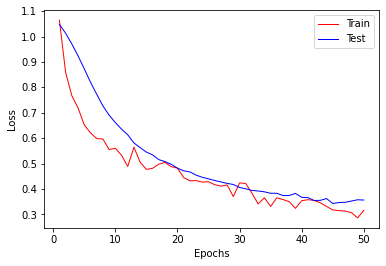

In [123]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ACCURACY曲线

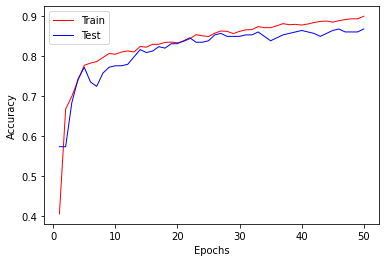

In [124]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 结果分析-与卷积模型对比

在其他超参数相同的情况下，空洞卷积的训练速度有明显提升。但是在验证集上的精度不如卷积神经网络，且从曲线上来看，验证的Loss曲线和Accuracy曲线的波动都明显大于卷积神经网络，可能是因为三层的空洞卷积传递的信息较深，使得在训练集上过拟合。

### 改变超参数

#### 减少卷积层数

In [113]:
class DilatedConvModule(nn.Module):
	def __init__(self):
		super(DilatedConvModule, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=2),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
		)
		self.fc = nn.Linear(64, num_classes)
	
	def forward(self, X):
		out = self.conv(X)
		out = F.avg_pool2d(out, 16)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out

In [114]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.001
batch_size = 512
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

3


In [115]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:1.1508	train_acc:0.27004608294930876	test_loss:1.0718	 test_acc0.6544117647058824
epoch:1	 train_loss:0.9495	train_acc:0.5548387096774193	test_loss:1.0450	 test_acc0.6654411764705882
epoch:2	 train_loss:0.8167	train_acc:0.6682027649769585	test_loss:1.0130	 test_acc0.6360294117647058
epoch:3	 train_loss:0.7857	train_acc:0.7317972350230415	test_loss:0.9780	 test_acc0.6176470588235294
epoch:4	 train_loss:0.6938	train_acc:0.7529953917050691	test_loss:0.9404	 test_acc0.6176470588235294
epoch:5	 train_loss:0.6901	train_acc:0.7576036866359447	test_loss:0.9005	 test_acc0.6176470588235294
epoch:6	 train_loss:0.6392	train_acc:0.7732718894009216	test_loss:0.8600	 test_acc0.6654411764705882
epoch:7	 train_loss:0.6195	train_acc:0.7861751152073733	test_loss:0.8178	 test_acc0.6875
epoch:8	 train_loss:0.6139	train_acc:0.7852534562211981	test_loss:0.7732	 test_acc0.7132352941176471
epoch:9	 train_loss:0.6385	train_acc:0.791705069124424	test_loss:0.7320	 test_acc0.7536764705882353
ep

#### 绘制曲线

LOSS曲线

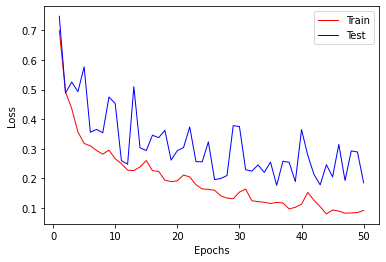

In [ ]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ACCURACY曲线

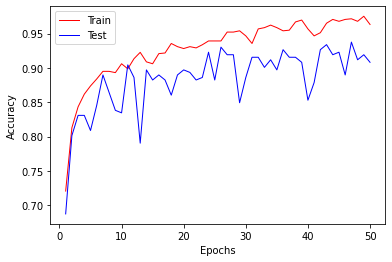

In [ ]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 分析-改变卷积层

在减少了卷积层之后，验证集的波动减少了，所以可能没有那么过拟合叻。

#### 更改Batchsize为128

In [99]:
class DilatedConvModule(nn.Module):
	def __init__(self):
		super(DilatedConvModule, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1),
			nn.BatchNorm2d(32),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=2),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True),
			nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=5),
			nn.BatchNorm2d(128),
			nn.ReLU(inplace=True)
		)
		self.fc = nn.Linear(128, num_classes)
	
	def forward(self, X):
		out = self.conv(X)
		out = F.avg_pool2d(out, 16)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out

In [116]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.001
batch_size = 128
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = DilatedConvModule().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

9


In [117]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:0.9372	train_acc:0.5622119815668203	test_loss:0.9994	 test_acc0.5955882352941176
epoch:1	 train_loss:0.6926	train_acc:0.7815668202764977	test_loss:0.8630	 test_acc0.7463235294117647
epoch:2	 train_loss:0.6172	train_acc:0.7824884792626728	test_loss:0.7174	 test_acc0.7536764705882353
epoch:3	 train_loss:0.5831	train_acc:0.7944700460829494	test_loss:0.6415	 test_acc0.7867647058823529
epoch:4	 train_loss:0.5362	train_acc:0.808294930875576	test_loss:0.5862	 test_acc0.8014705882352942
epoch:5	 train_loss:0.5158	train_acc:0.8193548387096774	test_loss:0.5263	 test_acc0.8345588235294118
epoch:6	 train_loss:0.4858	train_acc:0.8221198156682028	test_loss:0.4960	 test_acc0.8308823529411765
epoch:7	 train_loss:0.4610	train_acc:0.823963133640553	test_loss:0.4155	 test_acc0.8419117647058824
epoch:8	 train_loss:0.4339	train_acc:0.8414746543778802	test_loss:0.4147	 test_acc0.8455882352941176
epoch:9	 train_loss:0.4211	train_acc:0.8497695852534562	test_loss:0.4819	 test_acc0.845588235

#### 绘制曲线

LOSS曲线

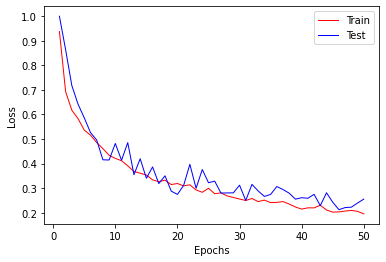

In [118]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

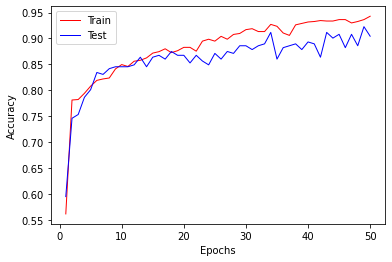

In [119]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 分析-增大Batch size

在增大了Batch Size之后，模型的效果有了较为显著的提高。验证集的精度有所上升且波动有明显下降。且提升的速度也较快。应该是在梯度下降中根据每一个batch计算出的梯度更加准确而且避过了一些Local Minima。

### 残差网络

# 三、任务3

## 3.1 任务内容

1. 任务具体要求 实现给定结构的残差网络，在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）
2. 任务目的
3. 任务算法或原理介绍
4. 任务所用数据集（若此前已介绍过则可略）

## 3.2 任务思路及代码

> 以文本步骤的形式简要介绍代码思路
1. 步骤1：……
2. 步骤2：……
3. ……

#### 读取数据以及数据预处理

In [102]:
transform = transforms.Compose([
	transforms.Resize((32, 32)),  #本次图片输入尺寸为（32，32）
	transforms.ToTensor(),
	transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

#### 搭建网络

In [103]:
class ResidualBlock(nn.Module):
	def __init__(self, inchannel, outchannel, stride=1):
		super(ResidualBlock, self).__init__()
		self.left = nn.Sequential(
			nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
			nn.BatchNorm2d(outchannel),
			nn.ReLU(inplace=True),
			nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(outchannel)
		)
		self.shortcut = nn.Sequential()
		if stride != 1 or inchannel != outchannel:
			self.shortcut = nn.Sequential(
				nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(outchannel)
			)
	
	def forward(self, x):
		out = self.left(x)
		out += self.shortcut(x)
		out = F.relu(out)
		return out

In [104]:
class ResNet(nn.Module):
	def __init__(self, block):
		super(ResNet, self).__init__()
		self.inchannel = 64
		self.conv1 = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0),
			nn.BatchNorm2d(64),
			nn.ReLU(inplace=True)
		)
		self.layer1 = self.make_layer(ResidualBlock, channels=64, blocks=2, stride=1)
		self.layer2 = self.make_layer(ResidualBlock, channels=128, blocks=2, stride=2)
		self.layer3 = self.make_layer(ResidualBlock, channels=256, blocks=2, stride=2)
		self.layer4 = self.make_layer(ResidualBlock, channels=512, blocks=2, stride=2)
		self.fc = nn.Linear(512, num_classes)
	
	def make_layer(self, block, channels, blocks, stride):
		strides = [stride] + [1] * (blocks - 1)
		layers = []
		for stride in strides:
			layers.append(block(self.inchannel, channels, stride))
			self.inchannel = channels
		return nn.Sequential(*layers)
	
	def forward(self, x):
		out = self.conv1(x)
		out = self.layer1(out)
		out = self.layer2(out)
		out = self.layer3(out)
		out = self.layer4(out)
		out = F.avg_pool2d(out, 4)
		out = torch.squeeze(out)
		out = self.fc(out)
		return out


#### 训练与测试

In [105]:
classes = ('bus', 'car', 'truck')
num_classes = 3
epochs = 50
lr = 0.01
batch_size = 128
device = torch.device("cuda:0")
vehicles_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
vehicles_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
print(len(vehicles_trainloader))
net = ResNet(ResidualBlock).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

9


In [106]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
	train_loss, train_acc = train_epoch(net, data_loader=vehicles_trainloader, device=device)
	test_loss, test_acc = test_epoch(net, data_loader=vehicles_testloader, device=device)
	train_loss_list.append(train_loss)
	train_acc_list.append(train_acc)
	test_loss_list.append(test_loss)
	test_acc_list.append(test_acc)
	print(f"epoch:{epoch}\t train_loss:{train_loss:.4f}\t"
	f"train_acc:{train_acc}\t"
	f"test_loss:{test_loss:.4f}\t test_acc{test_acc}")

epoch:0	 train_loss:1.8372	train_acc:0.5308755760368664	test_loss:2443.4877	 test_acc0.5735294117647058
epoch:1	 train_loss:0.7084	train_acc:0.7059907834101382	test_loss:1382.3260	 test_acc0.5735294117647058
epoch:2	 train_loss:0.5604	train_acc:0.8009216589861751	test_loss:15.3439	 test_acc0.6323529411764706
epoch:3	 train_loss:0.4405	train_acc:0.8341013824884793	test_loss:1.1252	 test_acc0.7904411764705882
epoch:4	 train_loss:0.3408	train_acc:0.8792626728110599	test_loss:2.7403	 test_acc0.7389705882352942
epoch:5	 train_loss:0.3038	train_acc:0.8866359447004608	test_loss:0.8302	 test_acc0.7279411764705882
epoch:6	 train_loss:0.2888	train_acc:0.8930875576036866	test_loss:0.3167	 test_acc0.8529411764705882
epoch:7	 train_loss:0.2431	train_acc:0.9161290322580645	test_loss:0.2414	 test_acc0.8639705882352942
epoch:8	 train_loss:0.2418	train_acc:0.9142857142857143	test_loss:0.2484	 test_acc0.9154411764705882
epoch:9	 train_loss:0.2150	train_acc:0.9207373271889401	test_loss:0.4566	 test_acc0.

#### 绘制曲线

LOSS曲线

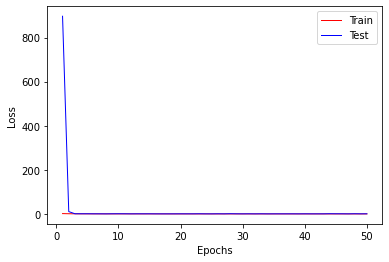

In [52]:
epoch_list = np.arange(1, 51)
plt.plot(epoch_list, train_loss_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_loss_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

ACCURACY曲线

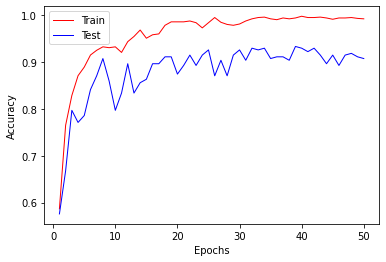

In [53]:
plt.plot(epoch_list, train_acc_list, color='red', linewidth=1.0, label='Train')
plt.plot(epoch_list, test_acc_list, color='blue', linewidth=1.0, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

 ## 3.3结果分析
1. 残差网络的训练时间相对较快，在有较多隐藏层的结构下仍然与普通卷积网络相近。对于模型的精度和LOSS曲线，是这三种模型中表现最好的，train acc高达0.99且没有发生过拟合，在验证集上的精度仍然高达0.91左右，表现很好，应该是计算残差防止其出现过拟合。从loss曲线来看，train loss起始值就很低，而test loss下降的很迅速且一直很平稳。


# A1 实验心得

> 1. 实验四的主要是在二维卷积神经网络上展开的，相比前面的实验，本次实验很多模板都是共用的，课件上也有很多的详细步骤，，按照这些步骤很容易完成实验。
> 2. 本次实验中主要的难点是理解卷积神经网络的基本原理和步骤，根据P学过的内容和PPT例子，不难理解。
> 3. 实验中空洞卷积神经网络比较困难，自己也是摸索了很长时间才完成。
> 4. 对于二维卷积实验结果中出现的过拟合现象，我思考过进行打乱数据集，应该能得到更好的结果。
> 5.由于时间关系，自己只选用了车辆数据集，没有使用去雾数据集，自己课后会花更多的时间在上面，进行测试。

# A2 参考文献

> 主要包含实验过程中涉及到的参考资料或者借鉴别人的材料等，如果没有可以不写。

1. 无